In [93]:
from eBallena import eBallena
from Data import FSDD
from Baseline import generateReservoir, generateTopologyInput, assignWeightsReservoir, assignWeightsInputs
from Utils import fastEval, contarEnergia, Parallel

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import pickle

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# ===============
#  LOAD DATASET
# ===============

fsdd = FSDD(time_bin=80, max_spikes=10, n_dim=26,  hop_lenght=400, random_state=88)

Cantidad de spikes: [7]


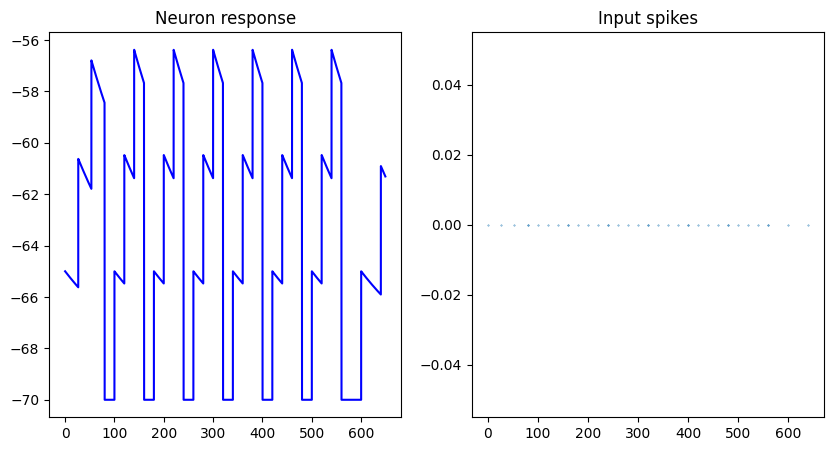

In [31]:
# ================================================================
#   PRIMERO UN BREVE ANALISIS PARA ENCONTRAR LA CONSTANTE TAU
# ================================================================
""" 
Se recomienda ugar con los hiperparametros tau y weight_in.

En esta celda se usa una sola neurona y un solo canal de una sola instancia de FSDD. 
El objetivo es ver como reaccionará una neurona frente a un input tipico del dataset.
Al ejecutar la celda se puede ver la respuesta en voltaje y numero de spikes de la neurona.

El objetivo es que para distintas instancias, la neurona haga spike un numero razonable de veces.
Razonable es mayor que uno y menor a 8. 
Muy pocos spikes no dan resolucion para realizar inferencias.
Muchos spikes hacen que la simulacion sea muy lenta y se sobreajuste.
"""


# ================
# HIPERPARAMETROS
tau    	   = 200
weight_in  = 5
refractory = 5
instance   = 4

# ==========================
# SELECCIONO UN SOLO INPUT 
# Y UNA SOLA NEURONA
syn_in = [(0,0,weight_in)]
instance = np.array(fsdd.d_train[instance])
channel0  = instance[ instance[:,1]==0 ][:,0].round(2)
channel0  = [ (time,0) for time in channel0 ]

# ==============
# CONFIGURACION
config = eBallena.createConfig(n_inputs=1, n_neu=1, tau=tau, max_sim_time=3_000, 
                               refractory_time=refractory, threshold=-55)

# ==============
#  SIMULACION
volt = eBallena.simulate( config, channel0, syn_in, [], mode='VOLTAGES' )
spk  = eBallena.simulate( config, channel0, syn_in, [], mode='STATE' )

# ==============
#      PLOT
print('Cantidad de spikes:',spk)

plt.figure( figsize=(10,5) )
plt.subplot(121)
plt.title('Neuron response')
eBallena.plotVoltage( volt, 0, config )
plt.subplot(122)
plt.title('Input spikes')
plt.scatter( np.array(channel0)[:,0],np.array(channel0)[:,1], s=0.1 )
plt.show()

In [74]:
# ================================================================
#   FUNCION PARA OBTENER METRICAS (ACCURACY, Y NUM_SPIKES)
# ================================================================

def get_metrics(hiperparams):
	tau, w_in, w_re, pneu_e = hiperparams

	# =================
	# GENERAR TOPOLOGIA
	connections_in, syn_type_in = generateTopologyInput(n_inputs=26,n_neu_reservoir=1000,
												  prob_connection=0.03)
	connections_re, neuron_type_re = generateReservoir(num_neuron=1000, prob_exitatory=pneu_e)

	syn_in = assignWeightsInputs(connections_in, syn_type_in, w_in)
	syn_re = assignWeightsReservoir(connections_re, neuron_type_re, w_re)

	# ==============
	# CONFIGURACION
	# DE SIMULACION
	config = eBallena.createConfig(n_inputs=26, n_neu=1000, tau=tau, max_sim_time=3_000, 
									refractory_time=5, threshold=-55)
	
	# ==============
	#  SIMULACION
	states_train = []
	for instance in fsdd.d_train[:10]:
		states_train.append( eBallena.simulate( config, instance, syn_in, syn_re, mode='STATE' ) )
	states_train = np.array(states_train)

	states_test = []
	for instance in fsdd.d_test[:10]:
		states_test.append( eBallena.simulate( config, instance, syn_in, syn_re, mode='STATE' ) )
	states_test = np.array(states_test)


	# ===============
	#   GET RESULTS
	acc        = fastEval( states_train, states_test, fsdd.t_train[:10], fsdd.t_test[:10] )
	num_spikes = states_test.sum(axis=1).mean()
	std_spikes = states_test.sum(axis=1).std()
	return (acc[0],acc[1], num_spikes,std_spikes)

In [56]:
# ===========================================
#  GENERAR COMBINACIONES DE HIPERPARAMETROS
# ===========================================

""" 
Las listas de tau y w_in fueron construidas "jugando" con los hiperparametros en la celda anterior.

La lista w_re fue construida notando que valores altos "parece que" mejoran accuracy pero 
elevan mucho el tiempo de simulacion

La lista prob_neu_e fue construida poniendo numeros por encima y por debajo del valor recomendado 
en el paper.
"""

list_tau        = [80,   120,  160,    200]		# TAU
list_w_in 	    = [2,    3,    4,      5]		# PESO SINAPTICO INPUT-RESERVOIR
list_w_re 	    = [0.5,  1.3,  2.1,    3.0]		# PESO SINAPTICO RESERVOIR-RESERVOIR
list_prob_neu_e = [0.65, 0.72, 0.78,   0.85]	# PROBABILIDAD DE QUE UNA NEU SEA EXITATORIA

all_params = []
for tau in list_tau:
    for w_in in list_w_in:
        for w_re in list_w_re:
            for pneu_e in list_prob_neu_e:
                all_params.append( (tau, w_in, w_re,pneu_e) )
                
all_params = np.random.permutation( all_params )

In [ ]:
# ==========================
#  EVALUACION EN PARALELO
# ===========================
"""
Interpretacion de los datos: 
Por cada elemento de la lista de parametros hay un resultado en la misma posicion en la lista results.
Cada result[i] contiene 5 ejecuciones.
Cada ejecucion simula todo el dataset (train y test) y obtiene las metricas.
Las metricas son: (accuracy_test, accuracy_train, num_spikes, std_spikes)
	acc       : El accuracy principal. Se entrena con d_train y se evalua con d_test.
    acc_train : Se entrena con d_train y se evalua con d_train (para medir sobreajuste).
    num_spikes: Promedio de cantidad de spikes con cada instancia del dataset.
    std_spikes: Desviacion estandar de cantidad de spikes con cada instancia del dataset.
Mientras más accuracy mejor, pero mientras más spikes peor. 
Más spikes=más energia gastada y mas tiempo de simulacion.
"""

# ==============
# GENERAR DATOS
def evaluar5veces( hiperparams ):
    return [ get_metrics(hiperparams) for _ in range(5)]

parallel = Parallel(evaluar5veces, n_processes=32)
results  = parallel.evaluateY(all_params)			# ESTA FUNCION DIVIDE LA LISTA Y LA ENVIA A 
													# DISTINTOS PROCESOS PARA EVALUAR EN PARALELO
													# 
# ==============
# GUARDAR DATOS                                     
params_repeated = np.repeat(all_params, 5, axis=0)
results_ 		= np.array(results).reshape(-1,4)
results_ 		= np.concatenate( (params_repeated, results), axis=1 )

col_names = ['tau','w_in','w_re','prob_neu_e','acc','acc_train','num_spikes','std_spikes']
results_ = pd.DataFrame(data=results_,columns=col_names)
results_.to_csv('datos_subrogados2.csv',index=False)